In [74]:
from src.pyssla_designer.config import config

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
from PIL import Image
import cv2

import math
from collections import Counter

In [76]:
# image_path = 'images/square_images/haikyuu_kageyama1.png'
image_path = 'images/haikyuu.png'

img = Image.open(image_path)
img_array = np.array(img)

In [77]:
if img_array.shape[-1] > 3:
    img_array = img_array[:, :, :3]

In [78]:
def init_config(canvas_multiplier=1):
    canvas_side = config['CANVAS_SIDE'] * canvas_multiplier
    colors = [config['WHITE'], config['BLACK'], config['BROWN'], config['RED'], config['ORANGE'],
              config['YELLOW'], config['GREEN'], config['BLUE'], config['PURPLE'], config['PINK']]
    color_names = ['white', 'black', 'brown', 'red', 'orange',
                   'yellow', 'green', 'blue', 'purple', 'pink']

    return canvas_side, colors, color_names

side_length, colors, color_names = init_config(canvas_multiplier=1)

assert len(colors) == len(color_names)
hex_to_name = {colors[i]: color_names[i] for i in range(len(colors))}

# canvas_size = (side_length, side_length) # use a square canvas for now
canvas_size = (3 * side_length, 2 * side_length)
canvas_size

(87, 58)

In [79]:
def quantize_to_palette(image_array, colors):
    palette = np.array([hex_to_rgb(c) for c in colors], dtype=np.float32)
    
    h, w, _ = image_array.shape
    pixels = image_array.reshape(-1, 3).astype(np.float32)
    
    distances = np.sqrt(np.sum((pixels[:, np.newaxis] - palette) ** 2, axis=2))
    
    closest_indices = np.argmin(distances, axis=1)
    
    quantized_pixels = palette[closest_indices]
    
    return quantized_pixels.reshape(h, w, 3).astype(np.uint8)

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

In [80]:
from src.pyssla_designer.downsampling import (claude_downscale_nearest_neighbor,
                                              claude_downscale_averaging,
                                              gemini_downscale_pre_sharpened_nearest,
                                              gemini_downscale_opencv_nearest,
                                              gemini_downscale_median_pooling)

In [81]:
downscale_function = claude_downscale_nearest_neighbor
# downscale_function = gemini_downscale_median_pooling

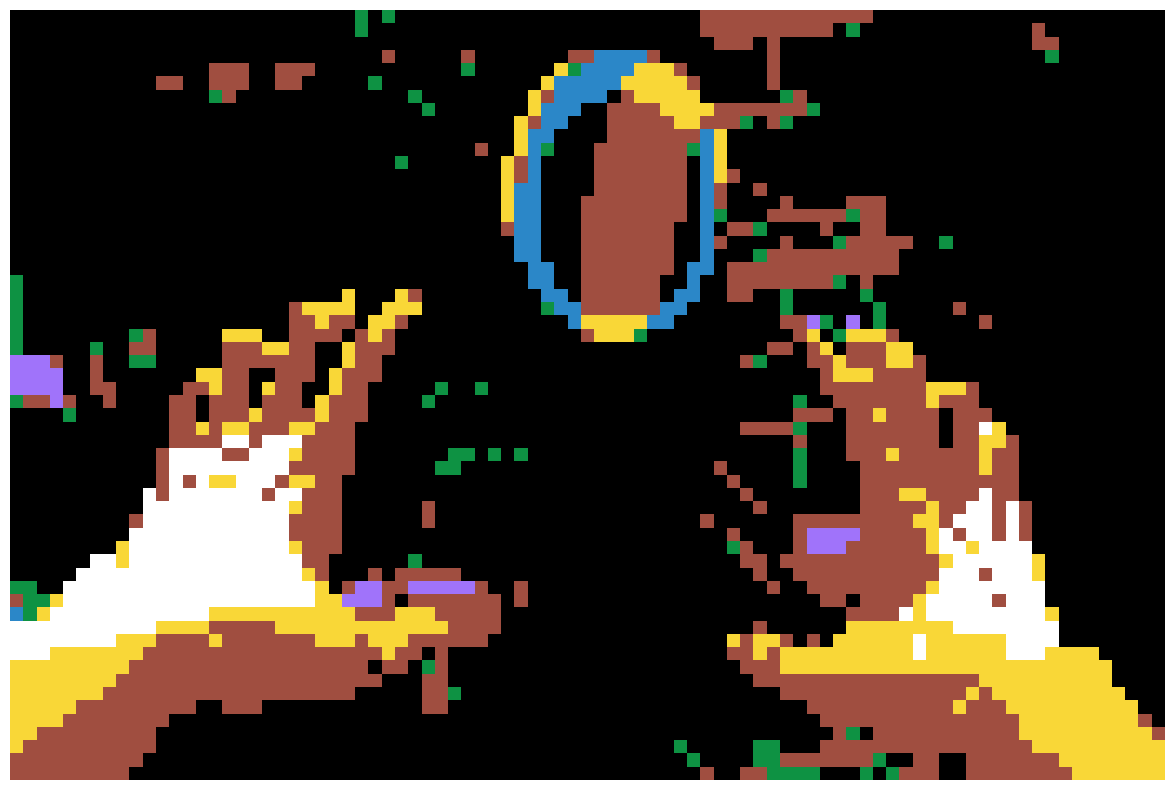

In [82]:
fig, axes = plt.subplots(figsize=(16, 8))
# axes = axes.flatten()

downsized_array = downscale_function(img_array, canvas_size)
quantized_array = quantize_to_palette(downsized_array, colors)

axes.imshow(quantized_array)
# axes.set_title(func_name)
axes.axis('off')

plt.tight_layout()
plt.show()

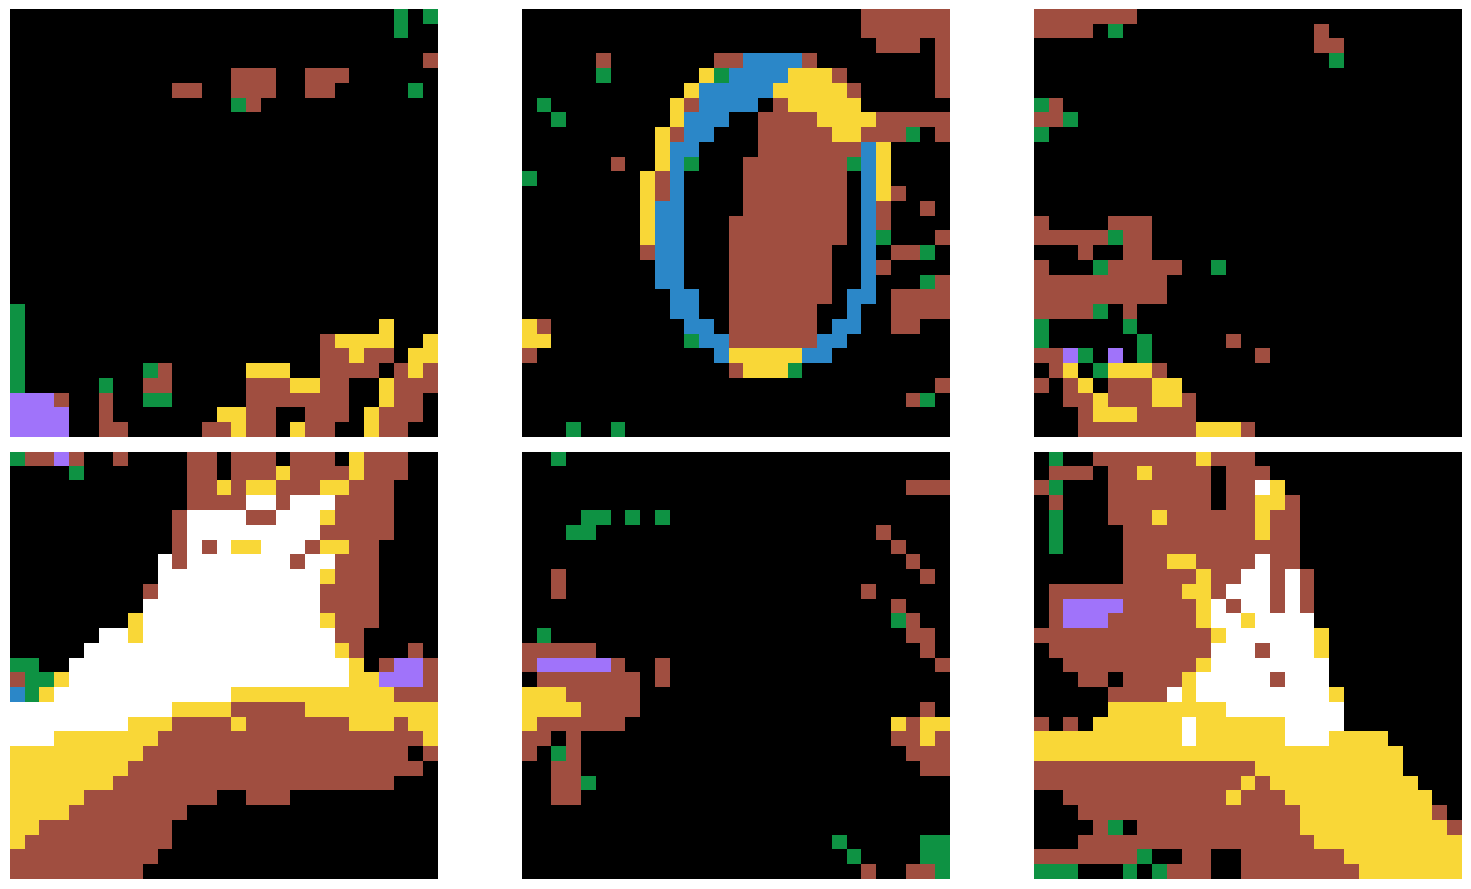

In [83]:
def split_image_into_subplots(image_array, side_length):
    """
    Splits an image into sections of size side_length x side_length and creates subplots.
    
    Args:
        image_array: Input image as numpy array (H, W, 3)
        side_length: Size of each section (height and width)
    
    Returns:
        fig: The figure object
        axes_list: List of axes objects
        sections: List of image sections corresponding to each axis
    """
    # Get image dimensions
    height, width, _ = image_array.shape
    
    # Calculate the number of sections in each dimension
    num_rows = height // side_length
    num_cols = width // side_length
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 9))
    
    # Flatten axes to make it easier to work with
    if num_rows == 1 and num_cols == 1:
        axes_list = [axes]
    elif num_rows == 1 or num_cols == 1:
        axes_list = axes.flatten()
    else:
        axes_list = axes.flatten()
    
    sections = []
    
    for i in range(num_rows):
        for j in range(num_cols):
            # Calculate the start and end indices for the current section
            start_row = i * side_length
            end_row = start_row + side_length
            start_col = j * side_length
            end_col = start_col + side_length
            
            # Extract the current section
            section = image_array[start_row:end_row, start_col:end_col]
            sections.append(section)
            
            # Get the current axis
            ax_idx = i * num_cols + j
            ax = axes_list[ax_idx]
            
            # Plot the section on the corresponding subplot
            ax.imshow(section)
            ax.axis('off')
    
    # Hide any unused axes
    total_sections = num_rows * num_cols
    for idx in range(len(sections), len(axes_list)):
        axes_list[idx].axis('off')
    
    plt.tight_layout()
    
    return fig, axes_list, sections

downsized_array = downscale_function(img_array, canvas_size)
quantized_array = quantize_to_palette(downsized_array, colors)

fig, axes_list, sections = split_image_into_subplots(quantized_array, side_length=29)
plt.show()

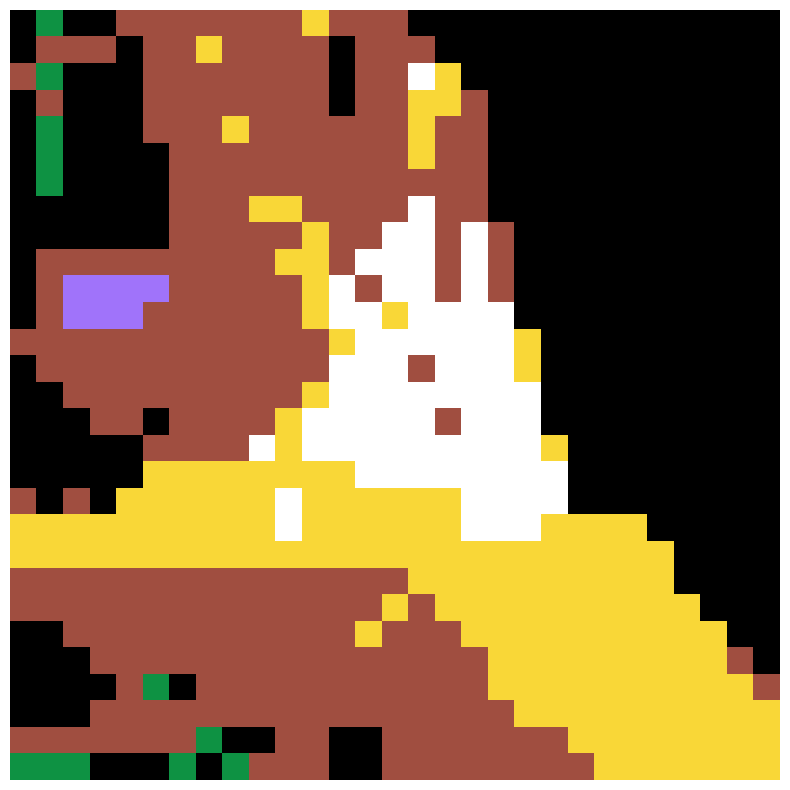

In [84]:
section_num = -1

if len(sections) > 0:
    fig_single, ax_single = plt.subplots(figsize=(10, 10))
    ax_single.imshow(sections[section_num])
    ax_single.axis('off')
    plt.show()

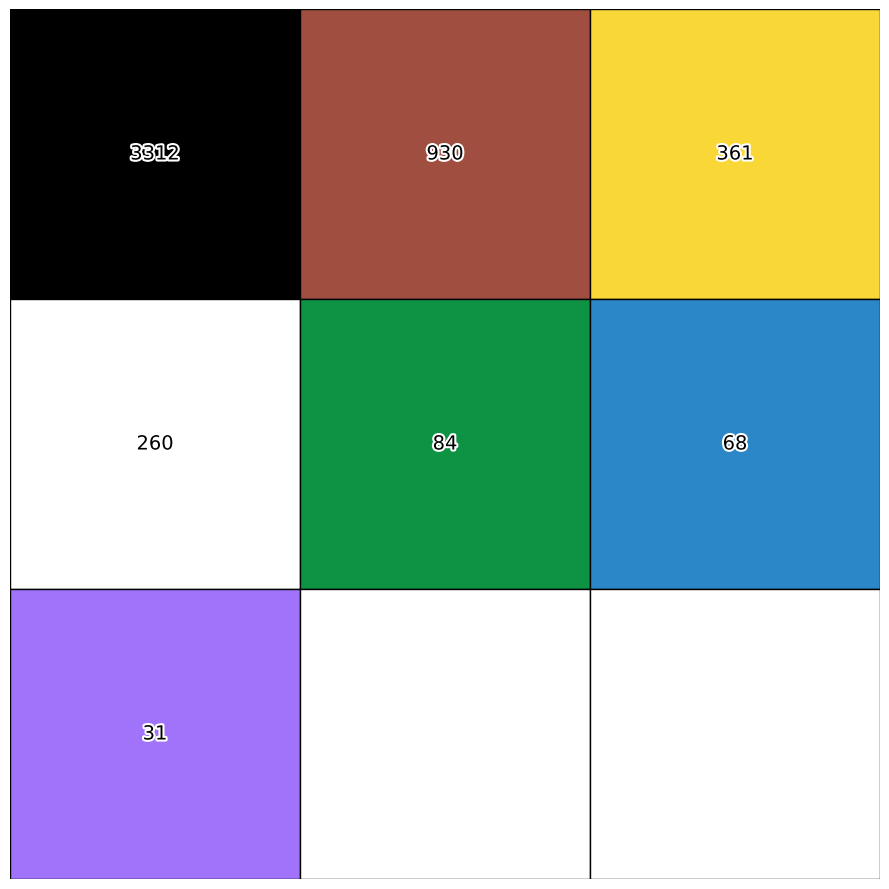

In [85]:
def get_color_info(quantized_array):
    pixels = quantized_array.reshape(-1, 3)
    unique_colors, counts = np.unique(pixels, axis=0, return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]

    colors, color_counts = [], []

    for idx in sorted_indices[:9]:
        color = unique_colors[idx]
        hex_color = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
        colors.append(hex_color)
        color_counts.append(counts[idx].item())

    return colors, color_counts

def plot_custom_matrix(ax, numbers, colors):
    if len(numbers) != 9 or len(colors) != 9:
        raise ValueError("Both 'numbers' and 'colors' must have exactly 9 elements.")
    
    matrix_numbers = np.array(numbers).reshape(3, 3)
    matrix_colors = np.array(colors).reshape(3, 3)
    
    ax.set_xticks([])
    ax.set_yticks([])

    for i in range(3):
        for j in range(3):
            rect = plt.Rectangle((j, i), 1, 1, facecolor=matrix_colors[i, j], edgecolor='black')
            ax.add_patch(rect)
            # ax.text(j + 0.5, i + 0.5, str(matrix_numbers[i, j]),
            #         ha='center', va='center', fontsize=14, color='black')
            text = ax.text(j + 0.5, i + 0.5, str(matrix_numbers[i, j]),
                         ha='center', va='center', fontsize=14, color='black',
                         path_effects=[
                             patheffects.withStroke(linewidth=3, foreground='white')
                         ])
    
    ax.set_xlim(0, 3)
    ax.set_ylim(3, 0)
    
    ax.set_aspect('equal')


fig, axes = plt.subplots(figsize=(16, 9))
# axes = axes.flatten()

downsized_array = claude_downscale_nearest_neighbor(img_array, canvas_size)
quantized_array = quantize_to_palette(downsized_array, colors)

quantized_colors, quantized_numbers = get_color_info(quantized_array)

if len(quantized_colors) == len(quantized_numbers) and 0 < len(quantized_numbers) < 9:
    quantized_colors.extend(['#ffffff'] * (9 - len(quantized_colors)))
    quantized_numbers.extend([''] * (9 - len(quantized_numbers)))

plot_custom_matrix(axes, quantized_numbers, quantized_colors)

axes.imshow(quantized_array)
# axes.set_title(func_name)
axes.axis('off')

plt.tight_layout()
plt.show()